Problem Statement:

In this challenge, participants will develop a predictive model capable of forecasting traffic volume at specific times, given various influential factors within the dataset.

Evaluation Metric:

The hackathon evaluation will be based on the Root Mean Squared Error (RMSE) metric.

In [2]:
import pandas as pd   # importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

In [3]:
# using both the files of train and test data to predict simultaneously
train_data = pd.read_csv("Train.csv")
test_data = pd.read_csv("Test.csv")  # Using this for prediction later

EDA - EXPLORATORY DATA ANALYSIS

In [4]:
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38373 entries, 0 to 38372
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Holiday             50 non-null     float64
 1   Temperature         38373 non-null  float64
 2   Rainfall_last_hour  38373 non-null  float64
 3   Snowfall_last_hour  38373 non-null  float64
 4   Cloud_Cover         38373 non-null  int64  
 5   Weather             38373 non-null  object 
 6   Weather_Desc        38373 non-null  object 
 7   TimeStamp           38373 non-null  object 
 8   Date                38373 non-null  object 
 9   Traffic_Vol         38373 non-null  int64  
dtypes: float64(4), int64(2), object(4)
memory usage: 2.9+ MB
None


In [5]:
print(train_data.describe())

       Holiday   Temperature  Rainfall_last_hour  Snowfall_last_hour  \
count     50.0  38373.000000        38373.000000        38373.000000   
mean       1.0    281.152767            0.327486            0.000128   
std        0.0     13.813324           50.194024            0.005924   
min        1.0      0.300000            0.000000            0.000000   
25%        1.0    271.910000            0.000000            0.000000   
50%        1.0    281.990000            0.000000            0.000000   
75%        1.0    292.140000            0.000000            0.000000   
max        1.0    310.970000         9831.414286            0.512857   

        Cloud_Cover   Traffic_Vol  
count  38373.000000  38373.000000  
mean      44.821098   3293.947567  
std       38.749566   1988.311540  
min        0.000000      4.000000  
25%        1.000000   1246.000000  
50%       40.000000   3425.000000  
75%       90.000000   4964.000000  
max      101.000000   7289.000000  


The reason print(train_data.describe()) does not include Weather, Weather_Desc, TimeStamp, and Date is that describe() only works on numerical columns by default.

To include them use following : include all command

In [6]:
print(train_data.describe(include='all'))

        Holiday   Temperature  Rainfall_last_hour  Snowfall_last_hour  \
count      50.0  38373.000000        38373.000000        38373.000000   
unique      NaN           NaN                 NaN                 NaN   
top         NaN           NaN                 NaN                 NaN   
freq        NaN           NaN                 NaN                 NaN   
mean        1.0    281.152767            0.327486            0.000128   
std         0.0     13.813324           50.194024            0.005924   
min         1.0      0.300000            0.000000            0.000000   
25%         1.0    271.910000            0.000000            0.000000   
50%         1.0    281.990000            0.000000            0.000000   
75%         1.0    292.140000            0.000000            0.000000   
max         1.0    310.970000         9831.414286            0.512857   

         Cloud_Cover       Weather Weather_Desc      TimeStamp      Date  \
count   38373.000000         38373        38373

In [6]:
print(train_data.isnull().sum())

Holiday               38323
Temperature               0
Rainfall_last_hour        0
Snowfall_last_hour        0
Cloud_Cover               0
Weather                   0
Weather_Desc              0
TimeStamp                 0
Date                      0
Traffic_Vol               0
dtype: int64


No null values are present in Train Data

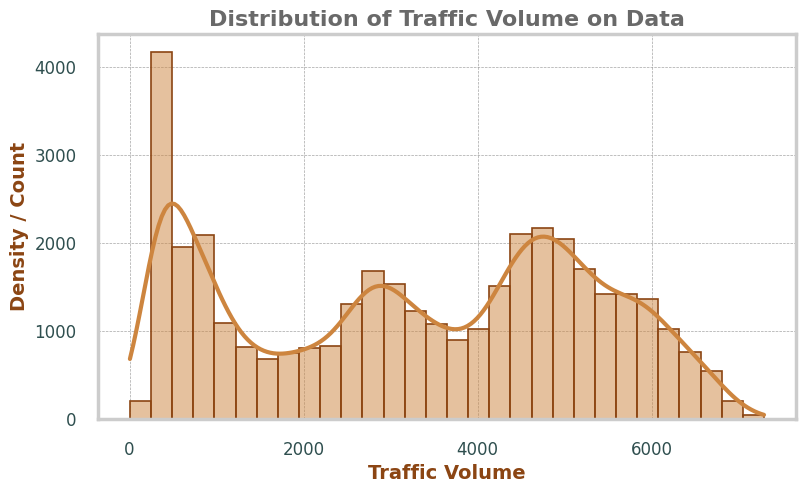

In [23]:
sns.set_style('whitegrid')
sns.set_context('poster')

plt.figure(figsize=(9, 5))
sns.histplot(train_data['Traffic_Vol'],
             bins=30,
             kde=True,
             color='peru',  # Custom color
             edgecolor='saddlebrown',  # Add edge color to bins
             linewidth=1.2)  # Width of the edge lines

plt.title("Distribution of Traffic Volume on Data", fontsize=16, fontweight='bold', color='dimgrey')
plt.xlabel('Traffic Volume', fontsize=14, fontweight='bold', color='saddlebrown')
plt.ylabel('Density / Count', fontsize=14, fontweight='bold', color='saddlebrown')

plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks(fontsize=12, color='darkslategrey')  # Customize x-axis tick labels
plt.yticks(fontsize=12, color='darkslategrey')  # Customize y-axis tick labels

plt.show()

Column 'TimeStamp' not found in the dataset. Skipping timestamp processing.
Column 'Weather_Desc' not found. Skipping one-hot encoding.


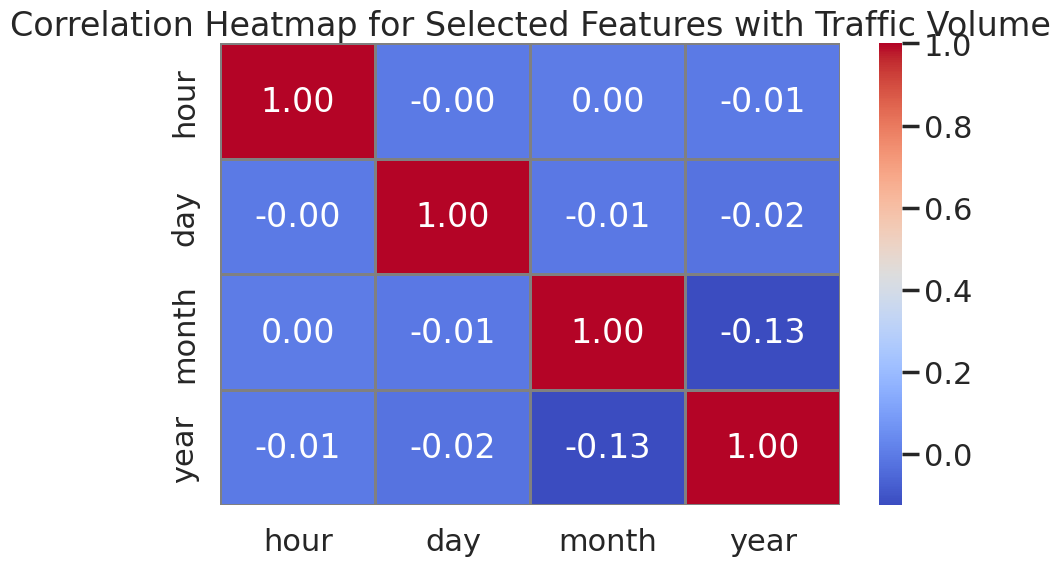

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38373 entries, 0 to 38372
Data columns (total 43 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   holiday                                           50 non-null     float64
 1   temperature                                       38373 non-null  float64
 2   rainfall_last_hour                                38373 non-null  float64
 3   snowfall_last_hour                                38373 non-null  float64
 4   cloud_cover                                       38373 non-null  int64  
 5   traffic_vol                                       38373 non-null  int64  
 6   hour                                              38373 non-null  int32  
 7   day                                               38373 non-null  int32  
 8   month                                             38373 non-null  int32  
 9   year             

In [33]:
# correlation map
if 'TimeStamp' in train_data.columns:
    train_data['TimeStamp'] = pd.to_datetime(train_data['TimeStamp'], errors='coerce')
    train_data['Hour'] = train_data['TimeStamp'].dt.hour
    train_data['Day'] = train_data['TimeStamp'].dt.day
    train_data['Month'] = train_data['TimeStamp'].dt.month
    train_data['Year'] = train_data['TimeStamp'].dt.year
    train_data.drop(columns=['TimeStamp'], inplace=True)
else:
    print("Column 'TimeStamp' not found in the dataset. Skipping timestamp processing.")

if 'Weather_Desc' in train_data.columns:
    train_data = pd.get_dummies(train_data, columns=['Weather_Desc'], drop_first=True)
else:
    print("Column 'Weather_Desc' not found. Skipping one-hot encoding.")

non_numeric_cols = train_data.select_dtypes(include=['object']).columns
if len(non_numeric_cols) > 0:
    print(f"Non-numeric columns found: {non_numeric_cols}")
    train_data.drop(columns=non_numeric_cols, inplace=True)

# List of columns that are expected to have a correlation with traffic volume
columns_of_interest = ['traffic_volume', 'hour', 'day', 'month', 'year', 'temp', 'humidity', 'wind_speed']

columns_of_interest = [col for col in columns_of_interest if col in train_data.columns]

correlation = train_data[columns_of_interest].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap="coolwarm", cbar=True, fmt='.2f', linewidths=1, linecolor='gray')
plt.title("Correlation Heatmap for Selected Features with Traffic Volume")
plt.show()

print(train_data.info())

Columns in the dataset: Index(['holiday', 'temperature', 'rainfall_last_hour', 'snowfall_last_hour',
       'cloud_cover', 'traffic_vol', 'hour', 'day', 'month', 'year',
       'weather_desc_approaching_thunderstorm',
       'weather_desc_approaching_thunderstorm_with_rain',
       'weather_desc_clear_skies', 'weather_desc_deep_snow',
       'weather_desc_dense_fog', 'weather_desc_drizzle_mixed_with_snow',
       'weather_desc_fine_fog', 'weather_desc_flurries',
       'weather_desc_fragmented_clouds', 'weather_desc_full_cloud_cover',
       'weather_desc_gentle_rain_shower', 'weather_desc_ice_rain',
       'weather_desc_icy_rain', 'weather_desc_intense_rainfall',
       'weather_desc_light_rain', 'weather_desc_mild_drizzle',
       'weather_desc_nearby_rain_showers',
       'weather_desc_nearby_thunderstorm_with_light_rain',
       'weather_desc_partly_cloudy_skies', 'weather_desc_scattered_clouds',
       'weather_desc_scattered_snowflakes',
       'weather_desc_severe_storm_with_hea

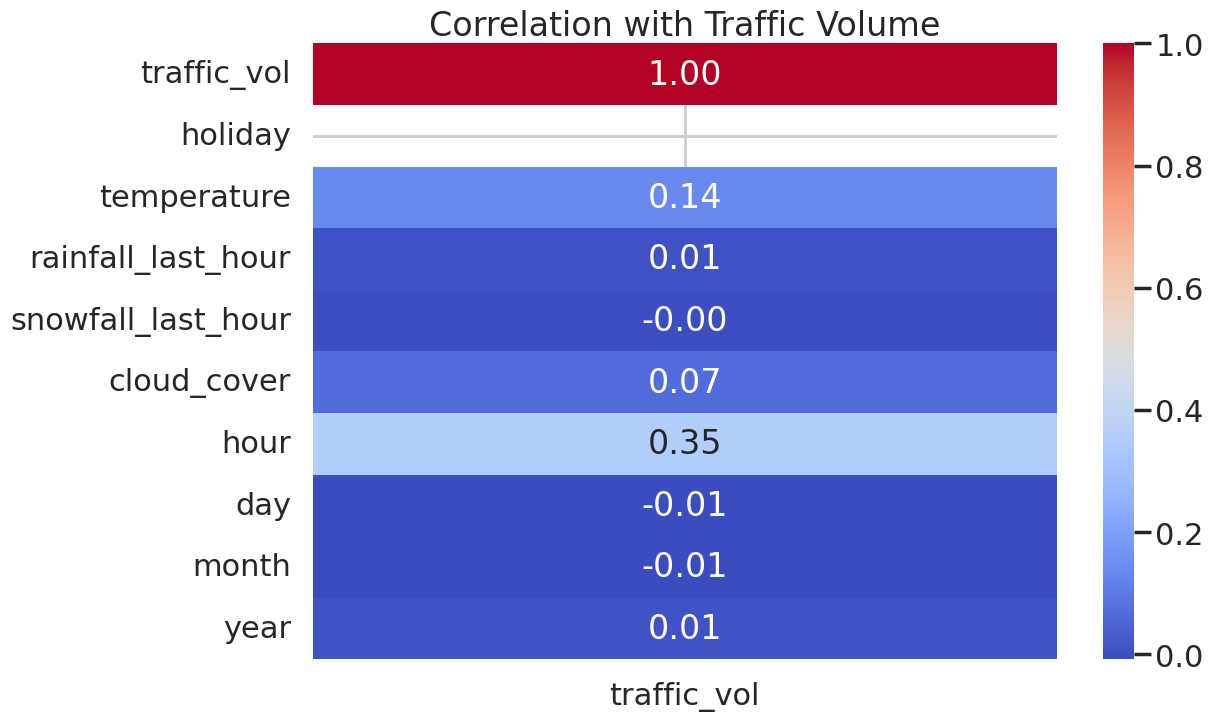

Correlation with Traffic_Vol:
                    traffic_vol
traffic_vol            1.000000
holiday                     NaN
temperature            0.137977
rainfall_last_hour     0.005540
snowfall_last_hour    -0.002285
cloud_cover            0.070310
hour                   0.354548
day                   -0.005872
month                 -0.008407
year                   0.009857


In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming train_data is already loaded

# Step 1: Check the actual column names (you can print this)
print("Columns in the dataset:", train_data.columns)

# Step 2: Define the columns of interest for correlation analysis
columns_of_interest = ['traffic_vol', 'holiday', 'temperature', 'rainfall_last_hour',
                       'snowfall_last_hour', 'cloud_cover', 'hour', 'day', 'month', 'year']

# Step 3: Check for missing columns
missing_columns = [col for col in columns_of_interest if col not in train_data.columns]
if missing_columns:
    print(f"Missing columns in the DataFrame: {missing_columns}")
else:
    # Filter the selected columns
    filtered_data = train_data[columns_of_interest]

    # Step 4: Calculate correlation with 'traffic_vol'
    correlation = filtered_data.corr()

    # Step 5: Plot the correlation heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation[['traffic_vol']], annot=True, cmap="coolwarm", fmt='.2f')
    plt.title("Correlation with Traffic Volume")
    plt.show()

    # Print the correlation values for 'traffic_vol'
    print("Correlation with Traffic_Vol:")
    print(correlation[['traffic_vol']])



In [40]:
print(train_data.columns)


Index(['holiday', 'temperature', 'rainfall_last_hour', 'snowfall_last_hour',
       'cloud_cover', 'traffic_vol', 'hour', 'day', 'month', 'year',
       'weather_desc_approaching_thunderstorm',
       'weather_desc_approaching_thunderstorm_with_rain',
       'weather_desc_clear_skies', 'weather_desc_deep_snow',
       'weather_desc_dense_fog', 'weather_desc_drizzle_mixed_with_snow',
       'weather_desc_fine_fog', 'weather_desc_flurries',
       'weather_desc_fragmented_clouds', 'weather_desc_full_cloud_cover',
       'weather_desc_gentle_rain_shower', 'weather_desc_ice_rain',
       'weather_desc_icy_rain', 'weather_desc_intense_rainfall',
       'weather_desc_light_rain', 'weather_desc_mild_drizzle',
       'weather_desc_nearby_rain_showers',
       'weather_desc_nearby_thunderstorm_with_light_rain',
       'weather_desc_partly_cloudy_skies', 'weather_desc_scattered_clouds',
       'weather_desc_scattered_snowflakes',
       'weather_desc_severe_storm_with_heavy_rain', 'weather_desc_

Result 1 : The most relevant feature correlated with traffic volume in the dataset is 'hour', which shows a moderate positive correlation. This suggests that traffic volume may vary with the time of day.